In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage import io

from vis import *
plt.style.use('dark_background')

In [3]:
from default import get_raster_arr
no_data = get_raster_arr("dem_at_clip.tif")["no_data"]

ModuleNotFoundError: No module named 'rvt'

In [47]:
def horizon_generate_coarse_dem(dem_fine,
                                pyramid_scale,
                                conv_from,
                                conv_to,
                                max_radius
                                ):
    # first reduce the size for the edge required for horizon search
    dem_fine = dem_fine[max_radius:-max_radius, max_radius:-max_radius]

    # get and adjust the array sizes
    in_shape = dem_fine.shape
    n_col_fine = in_shape[1]
    n_lin_fine = in_shape[0]
    n_lin_coarse = int(np.floor(n_lin_fine / pyramid_scale)) + 1
    n_col_coarse = int(np.floor(n_col_fine / pyramid_scale)) + 1
    # The corner points must fit in the new grid.
    # This is always the case with the left most column or the upper line.
    # But you have to adjust ne number of columns to the right and number of lines below.
    # The final number of columns/lines has to fullfil:
    #     n_coarse = pyramid_scale * n_fine + 1
    # columns
    mod_col = n_col_fine % pyramid_scale
    pad_col = 0
    if mod_col != 1:
        pad_col = np.abs(1 - mod_col)
    # lines
    mod_lin = n_lin_fine % pyramid_scale
    pad_lin = 0
    if mod_lin != 1:
        pad_lin = np.abs(1 - mod_lin)
    # Here we extend it to right and below, so padding with edge is OK
    # Edge-mode otherwise creates artefacts on left and above.
    dem_fine = np.pad(dem_fine, ((0, pad_lin), (0, pad_col)), mode="edge")

    # Once you have data in the shape appropriate for resizing,
    # pad the data to support np.move.
    dem_fine = np.pad(dem_fine, ((-conv_from, conv_to), (-conv_from, conv_to)), mode="symmetric")

    # Convolution (keep maximum)
    dem_convolve = np.zeros(dem_fine.shape)
    for i in np.arange(pyramid_scale) + conv_from:
        for j in np.arange(pyramid_scale) + conv_from:
            dem_convolve = np.maximum(dem_convolve, np.roll(dem_fine, (i, j), axis=(0, 1)))
    # Divide by pyramid_scale to account for the chage of resolution
    # (important for the angle computation later on)
    dem_convolve = dem_convolve / pyramid_scale

    # Consider only the selceted convoluted points according to the scale change.
    # As we select slice's end point make sure to consider at least 1 point more 
    # to the right / below to really include it (Python way of considering end index).
    dem_coarse = dem_convolve[-conv_from:(n_lin_coarse * pyramid_scale + 1):pyramid_scale,
                 -conv_from:(n_col_coarse * pyramid_scale + 1):pyramid_scale]

    # Final padding to enable searching the horizon over the edge:
    # use constant-mode set to the minimal height, so it doesn't 
    # affect the horizon estimation.
    dem_coarse = np.pad(dem_coarse, ((max_radius, max_radius), (max_radius, max_radius)), mode="constant",
                        constant_values=dem_coarse.min())

    return dem_coarse


def horizon_generate_pyramids(dem,
                              num_directions=4,
                              max_fine_radius=100,
                              max_pyramid_radius=7,
                              pyramid_scale=3,
                              ):
    # In the levels higher than 1, determine the minimal search distance
    # and number of search distances.
    # If you have for instance
    #     pyramid_scale = 3
    #     max_pyramid_radius = 10
    #     num_directions = 8
    # then you have original distances in level 0:
    # 1, 2, 3, ... 9, 10
    # In level 1, your resolution is 3-times coarser.
    # The first pixel that takes that this new resolution,
    # has in original distance value 12 (in coarse resolution 4):
    # 12->4, 15->5, 18->6 ... 27->9, 30->10
    # So you start in the level 1 with tmin_pyramid_radius=4
    # and you search from 4 to 10 distances (n_pyramid_radius=7)
    min_pyramid_radius = int(np.floor(max_pyramid_radius / pyramid_scale)) + 1
    n_pyramid_radius = max_pyramid_radius - min_pyramid_radius + 1

    # get the convolution window indices
    conv_to = int(np.floor(pyramid_scale / 2.))
    if (pyramid_scale % 2) == 0:
        conv_from = 1 - conv_to
    else:
        conv_from = -conv_to

    # initializations
    pyramid_levels = 0
    work = True
    pyramid = {}

    # Determine the number of levels and
    # the last radius to be used in the highest level.
    while work == True:
        _ = max_fine_radius / pyramid_scale ** pyramid_levels
        if _ > max_pyramid_radius:
            pyramid_levels = pyramid_levels + 1
        else:
            work = False
            last_radius = np.round(max_fine_radius / pyramid_scale ** pyramid_levels, decimals=0)

    # fill out the pyramid dict with the metadata required for horizont searching.
    for level in np.arange(pyramid_levels + 1):
        # the level 0 contains the other min_radius as the rest of levels
        if level == 0:
            min_radius = 1
            dem_fine = np.copy(np.pad(dem, max_pyramid_radius, mode="constant", constant_values=dem.min()))
        else:
            min_radius = min_pyramid_radius-1
            dem_fine = np.copy(dem_coarse)
        # the last level contains the other radius_pixels as the rest of levels
        if level == pyramid_levels:
            max_radius = last_radius
        else:
            max_radius = max_pyramid_radius
        # determine the dict of shifts
        shift = horizon_shift_vector(num_directions, max_radius, min_radius)
        dem_coarse = horizon_generate_coarse_dem(dem_fine, pyramid_scale, conv_from, conv_to, max_pyramid_radius)
        i_lin = np.arange(dem_fine.shape[0])
        i_col = np.arange(dem_fine.shape[1])

        pyramid[level] = {
            "num_directions": num_directions,
            "radius_pixels": max_radius,
            "min_radius": min_radius,
            "shift": shift,
            "dem": dem_fine,
            "i_lin": i_lin,
            "i_col": i_col,
        }

    return pyramid


def sky_illumination(dem,
                     resolution,
                     sky_model="overcast",
                     compute_shadow=True,
                     shadow_horizon_only=False,
                     max_fine_radius=100,
                     num_directions=32,
                     shadow_az=315,
                     shadow_el=35,
                     ve_factor=1,
                     no_data=None,
                     fill_no_data=False,
                     keep_original_no_data=False
                     ):
    """
    Compute topographic corrections for sky illumination.

    Parameters
    ----------
    shadow_horizon_only
    dem : numpy 2D array of elevation (DEM)
    resolution : dem pixel size
    sky_model : sky model, it can be 'overcast' or 'uniform'
    compute_shadow : bool compute shadow
    shadow_horizon_only : returns only dict {"shadow": shadow, "horizon": horizon}
    max_fine_radius : max shadow modeling distance [pixels]
    num_directions : number of directions to search for horizon
    shadow_az : shadow azimuth
    shadow_el : shadow elevation
    ve_factor : vertical exaggeration factor
    no_data : value that represents no_data, all pixels with this value are changed to np.nan
    fill_no_data : if True it fills where np.nan (no_data) with mean of surrounding pixels (3x3)
    keep_original_no_data : if True it changes all output pixels to np.nan where dem has no_data

    Returns
    -------
    sky_illum_out : 2D numpy result array
    """
    # standard pyramid settings
    pyramid_scale = 2
    max_pyramid_radius = 20

    if not (1000 >= ve_factor >= -1000):
        raise Exception("rvt.vis.sky_illumination: ve_factor must be between -1000 and 1000!")
    if shadow_az > 360 or shadow_az < 0:
        raise Exception("rvt.vis.sky_illumination: shadow_az must be between 0 and 360!")
    if shadow_el > 90 or shadow_el < 0:
        raise Exception("rvt.vis.sky_illumination: shadow_el must be between 0 and 90!")
    if no_data is None and fill_no_data:
        warnings.warn("rvt.vis.sky_illumination: In order to fill no data (fill_no_data = True) you have to input"
                      " no_data!")
    if (no_data is None or not fill_no_data) and keep_original_no_data:
        warnings.warn("rvt.vis.sky_illumination: In order to keep original no data (keep_original_no_data = True)"
                      " you have to input no_data and fill_no_data has to be True!")

    # change no_data to np.nan
    idx_no_data = None
    if no_data is not None:
        if keep_original_no_data:  # save indexes where is no_data
            if np.isnan(no_data):
                idx_no_data = np.where(np.isnan(dem))
            else:
                idx_no_data = np.where(dem == no_data)
        dem[dem == no_data] = np.nan

    dem = dem.astype(np.float32)
    dem = dem * ve_factor

    # fill no data with mean of surrounding pixels
    if fill_no_data:
        dem = fill_where_nan(dem)

    if sky_model.lower() == "overcast":
        compute_overcast = True
        compute_uniform = False
    elif sky_model.lower() == "uniform":
        compute_overcast = False
        compute_uniform = True
    else:
        raise Exception("rvt.vis.sky_illumination: sky_model must be overcast or uniform!")

    # generate slope and aspect
    _ = slope_aspect(np.pad(dem, max_pyramid_radius, mode="symmetric"), resolution, resolution)
    slope = _["slope"]
    aspect = _["aspect"]

    # build DEM pyramids
    pyramid = horizon_generate_pyramids(dem,
                                        num_directions=num_directions,
                                        max_fine_radius=max_fine_radius,
                                        max_pyramid_radius=max_pyramid_radius,
                                        pyramid_scale=pyramid_scale, )
    n_levels = np.max([i for i in pyramid])

    # get the convolution window indices
    conv_to = int(np.floor(pyramid_scale / 2.))
    if (pyramid_scale % 2) == 0:
        conv_from = 1 - conv_to
    else:
        conv_from = -conv_to
    # directional halve-resolution for integration limits
    da = np.pi / num_directions

    # init the intermediate results for uniform SI
    uniform_a = np.zeros((dem.shape[0] + 2 * max_pyramid_radius, dem.shape[1] + 2 * max_pyramid_radius),
                         dtype=np.float32)
    uniform_b = np.copy(uniform_a)
    # init the output for overcast SI
    if compute_overcast:
        overcast_out = np.zeros(dem.shape, dtype=np.float32)
        overcast_c = np.zeros((dem.shape[0] + 2 * max_pyramid_radius, dem.shape[1] + 2 * max_pyramid_radius),
                              dtype=np.float32)
        overcast_d = np.copy(overcast_c)
    else:
        overcast_out = None
    # init the output for shadows
    if compute_shadow:
        # use closest direction from pyramids as proxy for shadow azimuth
        # (just in case it is not the same as standard directions)
        _ = np.array([d for d in pyramid[0]["shift"]])
        i = np.argmin(np.abs(_ - (360 - shadow_az)))
        shadow_az = _[i]
        # binary shadows
        shadow_out = np.zeros(dem.shape, dtype=np.float32)
        # height of horizon in degrees
        horizon_out = np.zeros(dem.shape, dtype=np.float32)
        # overcast model + binary shadow
        if compute_overcast:
            overcast_sh_out = np.zeros(dem.shape, dtype=np.float32)
        else:
            overcast_sh_out = None
        # uniform model + binary shadow
        uniform_sh_out = np.zeros(dem.shape, dtype=np.float32)
    else:
        shadow_out = None
        horizon_out = None
        overcast_sh_out = None
        uniform_sh_out = None

    # search for horizon in each direction...
    for i_dir, direction in enumerate(pyramid[0]["shift"]):
        dir_rad = np.radians(direction)
        # reset maximum at each iteration (direction)
        max_slope = np.zeros(pyramid[n_levels]["dem"].shape, dtype=np.float32) - 1000

        for i_level in reversed(range(n_levels + 1)):
            height = pyramid[i_level]["dem"]
            move = pyramid[i_level]["shift"]

            # ... and to the search radius
            for i_rad, radius in enumerate(move[direction]["distance"]):
                # get shift index from move dictionary
                shift_indx = move[direction]["shift"][i_rad]
                # estimate the slope
                _ = np.maximum((np.roll(height, shift_indx, axis=(0, 1)) - height) / radius, 0.)
                # compare to the previus max slope and keep the larges
                max_slope = np.maximum(max_slope, _)

            # resample the max_slope to a lower pyramid level
            if i_level > 0:
                lin_fine = pyramid[i_level - 1]["i_lin"] + (
                        conv_from + max_pyramid_radius * pyramid_scale - max_pyramid_radius)
                col_fine = pyramid[i_level - 1]["i_col"] + (
                        conv_from + max_pyramid_radius * pyramid_scale - max_pyramid_radius)
                lin_coarse = pyramid[i_level]["i_lin"] * pyramid_scale
                col_coarse = pyramid[i_level]["i_col"] * pyramid_scale
                interp_spline = scipy.interpolate.RectBivariateSpline(lin_coarse, col_coarse, max_slope, kx=1, ky=1)
                max_slope = interp_spline(lin_fine, col_fine)

        # convert to angle in radians and compute directional output
        _ = np.arctan(max_slope)
        uniform_a = uniform_a + (np.cos(_)) ** 2
#         _d_aspect = np.sin((dir_rad - da) - aspect) - np.sin((dir_rad + da) - aspect)
        _d_aspect = -2 * np.sin(da) * np.cos(dir_rad - aspect)
        uniform_b = uniform_b + np.maximum(_d_aspect * (np.pi / 4. - _ / 2. - np.sin(2. * _) / 4.), 0)
        if compute_overcast:
            _cos3 = (np.cos(_)) ** 3
            overcast_c = overcast_c + np.maximum(_cos3, 0)
            overcast_d = overcast_d + np.maximum(_d_aspect * (2. / 3. - np.cos(_) + _cos3 / 3.), 0)
        if compute_shadow and (direction == shadow_az):
            horizon_out = np.degrees(_[max_pyramid_radius:-max_pyramid_radius, max_pyramid_radius:-max_pyramid_radius])
            shadow_out = (horizon_out < shadow_el) * 1
            if shadow_horizon_only:
                # change result to np.nan where dem is no_data
                if no_data is not None and keep_original_no_data:
                    shadow_out[idx_no_data] = np.nan
                    horizon_out[idx_no_data] = np.nan
                return {"shadow": shadow_out, "horizon": horizon_out}
        
    # because of numeric stabilty check if the uniform_b is less then pi and greater than 0
    uniform_out = (da) * np.cos(slope) * uniform_a + np.sin(slope) * uniform_b
    uniform_out = uniform_out[max_pyramid_radius:-max_pyramid_radius, max_pyramid_radius:-max_pyramid_radius]
    
    if compute_overcast:
        # because of numeric stabilty check if the overcast_d is greater than 0
        overcast_out = (2. * da / 3.) * np.cos(slope) * overcast_c + np.sin(slope) * overcast_d
        overcast_out = overcast_out[max_pyramid_radius:-max_pyramid_radius, max_pyramid_radius:-max_pyramid_radius]
        overcast_out = 0.33 * uniform_out + 0.67 * overcast_out
        overcast_out = overcast_out / overcast_out.max()
    if compute_shadow:
        uniform_sh_out = (0.8 * uniform_out + 0.2 * shadow_out)
        if compute_overcast:
            overcast_sh_out = (0.8 * overcast_out + 0.2 * shadow_out)

    # normalize
    uniform_out = uniform_out / np.pi

    # # return results within dict
    # dict_sky_illumination = {"uniform": uniform_out,
    #                          "overcast": overcast_out,
    #                          "shadow": shadow_out,
    #                          "horizon": horizon_out,
    #                          "uniform_shaded": uniform_sh_out,
    #                          "overcast_shaded": overcast_sh_out,
    #                          }
    # dict_sky_illumination = {k: v for k, v in dict_sky_illumination.items() if v is not None}  # filter out none
    # return dict_sky_illumination

    # output
    if compute_uniform and not compute_shadow:
        # change result to np.nan where dem is no_data
        if no_data is not None and keep_original_no_data:
            uniform_out[idx_no_data] = np.nan
        return uniform_out
    elif compute_uniform and compute_shadow:
        # change result to np.nan where dem is no_data
        if no_data is not None and keep_original_no_data:
            uniform_sh_out[idx_no_data] = np.nan
        return uniform_sh_out
    elif compute_overcast and not compute_shadow:
        # change result to np.nan where dem is no_data
        if no_data is not None and keep_original_no_data:
            overcast_out[idx_no_data] = np.nan
        return overcast_out
    elif compute_overcast and compute_shadow:
        # change result to np.nan where dem is no_data
        if no_data is not None and keep_original_no_data:
            overcast_sh_out[idx_no_data] = np.nan
        return overcast_sh_out


def shadow_horizon(dem,
                   resolution,
                   shadow_az=315,
                   shadow_el=35,
                   ve_factor=1,
                   no_data=None,
                   fill_no_data=False,
                   keep_original_no_data=False
                   ):
    """
    Compute shadow and horizon.

    Parameters
    ----------
    dem : numpy 2D array of elevation (DEM)
    resolution : raster resolution
    shadow_az : shadow azimuth
    shadow_el : shadow elevation
    ve_factor : vertical exaggeration factor
    no_data : value that represents no_data, all pixels with this value are changed to np.nan
    fill_no_data : if True it fills where np.nan (no_data) with mean of surrounding pixels (3x3)
    keep_original_no_data : if True it changes all output pixels to np.nan where dem has no_data

    Returns
    -------
    {"shadow": shadow 2D np.array, "horizon": horizon 2D np.array}
    """
    if not (1000 >= ve_factor >= -1000):
        raise Exception("rvt.vis.shadow_horizon: ve_factor must be between -1000 and 1000!")
    if shadow_az > 360 or shadow_az < 0:
        raise Exception("rvt.vis.shadow_horizon: shadow_az must be between 0 and 360!")
    if shadow_el > 90 or shadow_el < 0:
        raise Exception("rvt.vis.shadow_horizon: shadow_el must be between 0 and 90!")
    if no_data is None and fill_no_data:
        warnings.warn("rvt.vis.shadow_horizon: In order to fill no data (fill_no_data = True) you have to input"
                      " no_data!")
    if (no_data is None or not fill_no_data) and keep_original_no_data:
        warnings.warn("rvt.vis.shadow_horizon: In order to keep original no data (keep_original_no_data = True)"
                      " you have to input no_data and fill_no_data has to be True!")

    return sky_illumination(dem=dem, resolution=resolution, shadow_horizon_only=True, shadow_el=shadow_el,
                            shadow_az=shadow_az, ve_factor=ve_factor, no_data=no_data, fill_no_data=fill_no_data,
                            keep_original_no_data=keep_original_no_data)


def fill_where_nan(dem):
    """Replaces np.nan values. It takes nan surrounding (neighbor) cells (3x3), if number of nans <= max_nan_nr it
    calculates mean of not nans and writes mean to the center nan pixel.
    Function iterates and first calculates areas where is less nan values in the surrounding (neighbour) cells."""
    if np.all(~np.isnan(dem)):  # if there is no nan return dem
        return dem

    dem_out = np.copy(dem)
    mask = np.isnan(dem_out)
    dem_out[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), dem_out[~mask])
    return dem_out

In [68]:

dem = io.imread(r"/home/klemen/Downloads/dem_at_clip.tif")[:2000,:2000]
#dem[:200,:] = np.nan
#dem[:,:200] = np.nan
#dem[-200:,:] = np.nan
#dem[:,-200:] = np.nan
dem = np.zeros((600,600))
dem[300,300] = 20
print(dem.min(),dem.max())
#plt.imshow(dem)
#plt.show()
print(dem.mean(), dem.min(), dem.max())

0.0 20.0
5.555555555555556e-05 0.0 20.0


In [69]:
np.sum(np.isnan(dem))

0

In [78]:
c = sky_illumination(dem,
                     1,
                     sky_model="overcast",
                     compute_shadow=False,
                     shadow_horizon_only=False,
                     max_fine_radius=100,
                     num_directions=32,
                     shadow_az=315,
                     shadow_el=35,
                     ve_factor=0.2,
                     no_data=np.nan,
                     fill_no_data=True,
                     keep_original_no_data=True
                     )

1.0

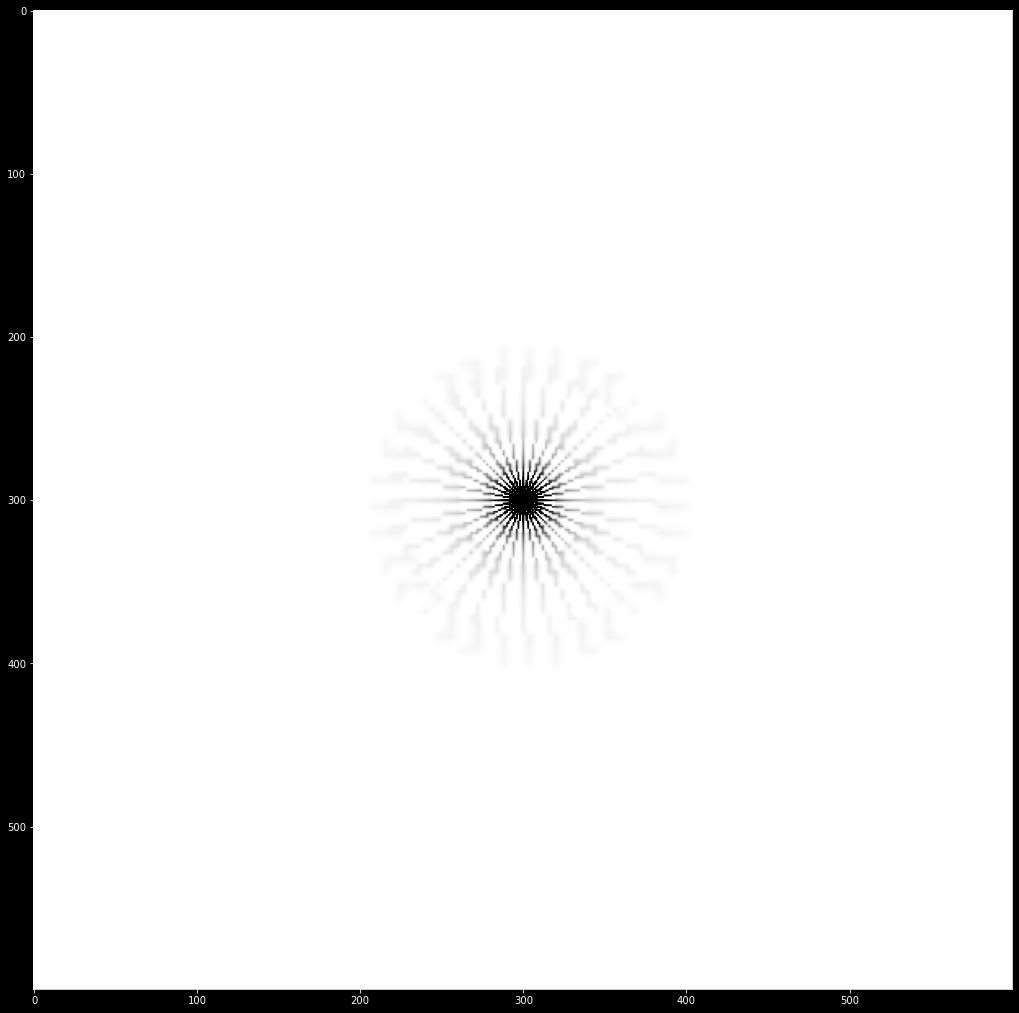

In [81]:
plt.figure(figsize=(18,18))
plt.imshow(c, cmap="gray", vmin=0.998, vmax=1)
# plt.imshow(dem, cmap="gray", vmin=-2000, vmax=1)
# plt.imshow(c[200:400,200:400], cmap="gray", vmin=0.9099, vmax=1)
#plt.plot(100,100, "oc")
c.max()

array([1.        , 0.99999973, 0.99999891, 0.99999754, 0.99999563,
       0.99999318, 0.99999018, 0.99998663, 0.99998255, 0.99998215,
       0.99998174, 0.99998134, 0.99998092, 0.99998051, 0.99998009,
       0.99997966, 0.99997923, 0.99996491, 0.99994688, 0.99992514,
       0.9998997 , 0.99989705, 0.99989437, 0.99989165, 0.9998889 ,
       0.9998858 , 0.99988267, 0.99987948, 0.99987626, 0.99987261,
       0.9998689 , 0.99986515, 0.99986134, 0.99985699, 0.99985257,
       0.99984809, 0.99984354, 0.99983831, 0.99983299, 0.99982758,
       0.9998221 , 0.99981572, 0.99980923, 0.99980264, 0.99979593,
       0.99978805, 0.99978003, 0.99977186, 0.99976355, 0.99975367,
       0.99974359, 0.99973331, 0.99972283, 0.9997102 , 0.99969729,
       0.99968411, 0.99967065, 0.99965414, 0.99963725, 0.99961996,
       0.99960229, 0.99958134, 0.99955987, 0.99953541, 0.99951032,
       0.99948153, 0.99945196, 0.99941776, 0.99938258, 0.99934154,
       0.99929925, 0.99924941, 0.99919798, 0.99913668, 0.99907

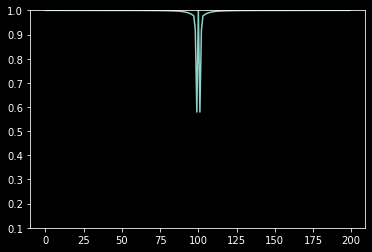

In [80]:
x = c[200:400, 300]
plt.figure()
plt.plot(range(x.shape[0]), x)
plt.ylim((0.1,1))
# plt.plot(range(x.shape[0]), a)
#x.shape[0]
x

In [58]:
# x = c[200:400, 300]
# plt.figure()
# plt.plot(range(x.shape[0]), x)
# #x.shape[0]

In [59]:
a = c[200:400, 300]

In [60]:
dem = np.zeros((10,1))
dem[5]=20

In [61]:
plt.figure()
plt.imshow(p[3]["dem"])
plt.show()

NameError: name 'p' is not defined

<Figure size 432x288 with 0 Axes>

In [62]:
slp = np.arange(10)*10/180*np.pi
slp

array([0.        , 0.17453293, 0.34906585, 0.52359878, 0.6981317 ,
       0.87266463, 1.04719755, 1.22173048, 1.3962634 , 1.57079633])

In [63]:
for s in slp:
    y = 0
    for a in azm:
        x = np.maximum((np.cos(s)*np.cos(elv ) + np.sin(s)*np.sin(elv )*np.cos(a)) * np.cos(elv), 0)
        y = y + np.sum(x)
    print (y)

NameError: name 'azm' is not defined